## Packages + support code needed:

These include many of the familiar packages, and an excerpt from the pygeotools package, imported as individual functions thanks to David and Shashank. I am running this notebook on Windows, and because of some apparant problems with system paths to gdal in rasterio on Windows I also ran `from osgeo import gdal` as a work-around thanks to much advice and troubleshooting with Amanda.  

In [1]:
# Import packages
from osgeo import gdal 
import numpy as np
import rasterio as rio
from rasterio import plot, mask
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import rioxarray as rioxarray
import geopandas as gpd
import astropy as ap

In [2]:
#Compiled from pygeotools (dshean) and himat2cryo repositories
#given to me by Shashank

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    #added to original code:
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=False, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = dem.mask
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype), size

In [3]:
#Define diverging color-ramp used in entire notebook
#color = 'PiYG'#Pink and Green
color = 'RdBu'#Red and Blue
#color = 'RdYlGn' #Red and Green with yellow in middle

## Methods with code

### Loading differenced data


In [4]:
fns_0 = r"C:\Users\Amanda\Documents\GitHub\micro_dem_differencing\micro_dem_diff\Data_Analysis_Ready\wsyr1_20201109_KID13_sfm.tif"
fns_1 = r"C:\Users\Amanda\Documents\GitHub\micro_dem_differencing\micro_dem_diff\Data_Analysis_Ready\wsyr1_20210208_KID13_sfm.tif"
fns_2 = r"C:\Users\Amanda\Documents\GitHub\micro_dem_differencing\micro_dem_diff\Data_Analysis_Ready\wsyr1_20210406_KID13_sfm.tif"
fns_3 = r"C:\Users\Amanda\Documents\GitHub\micro_dem_differencing\micro_dem_diff\Data_Analysis_Ready\wsyr1_20210513_KID13_sfm.tif"

In [5]:
sfm0 = rioxarray.open_rasterio(fns_0, mask_and_scale= True).squeeze()
sfm1 = rioxarray.open_rasterio(fns_1, mask_and_scale= True).squeeze()
sfm2 = rioxarray.open_rasterio(fns_2, mask_and_scale= True).squeeze()
sfm3 = rioxarray.open_rasterio(fns_3, mask_and_scale= True).squeeze()

In [6]:
sfm1_match = sfm1.assign_coords({
    "x": sfm0.x,
    "y": sfm0.y,
})

sfm2_match = sfm2.assign_coords({
    "x": sfm0.x,
    "y": sfm0.y,
})

sfm3_match = sfm3.assign_coords({
    "x": sfm0.x,
    "y": sfm0.y,
})

In [7]:
da_extent = sfm0.rio.bounds()

In [8]:
diff1_2 = sfm1_match-sfm0
diff1_3 = sfm2_match-sfm0
diff1_4 = sfm3_match-sfm0

In [9]:
diff1_2

<xarray.DataArray (y: 8378, x: 1314)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 4.989e+03 4.989e+03 ... 5.002e+03 5.002e+03
  * y            (y) float64 5.098e+03 5.098e+03 ... 5.014e+03 5.014e+03
    spatial_ref  int32 0

## Loading LiDAR data

In [10]:
fnl_0 = r"C:\Users\Amanda\Documents\GitHub\micro_dem_differencing\micro_dem_diff\Data_Analysis_Ready\wsyr1_20201109_KID13_LiDAR.tif"
fnl_1 = r"C:\Users\Amanda\Documents\GitHub\micro_dem_differencing\micro_dem_diff\Data_Analysis_Ready\wsyr1_20210513_KID13_LiDAR.tif"

In [11]:
lidar0 = rioxarray.open_rasterio(fnl_0, mask_and_scale= True).squeeze()
lidar1 = rioxarray.open_rasterio(fnl_1, mask_and_scale= True).squeeze()

In [12]:
ds_lidar_reproj = lidar1.rio.reproject_match(lidar0, resampling = 3)
diff_lidar = ds_lidar_reproj- lidar0

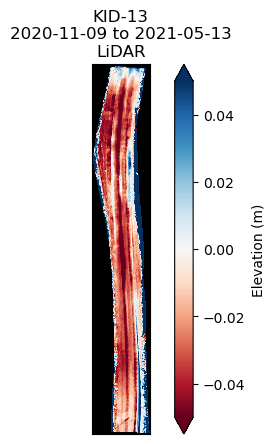

In [13]:
fig, ax = plt.subplots()

m = ax.imshow(diff_lidar, cmap = 'RdBu', vmin=-0.05, vmax=0.05)
ax.set_title('KID-13\n2020-11-09 to 2021-05-13\nLiDAR')
fig.colorbar(m, label='Elevation (m)', extend='both', ax=ax)
ax.set_facecolor('k')
ax.set_xticks(())
ax.set_yticks(());

### High-pass Gaussian filtering

This is where the high-pass filter shines, allowing me to take another difference that eliminates the noise seen in the other difference. 

In [14]:
#This controls width of gaussian kernel standard deviation in pixels
#50 chosen for full resolution
#10 for overview 2
sigma = 50
diff_smooth1_2, size = gauss_fltr_astropy_fft(diff1_2, sigma = sigma, origmask=True)
diff_smooth1_3, size = gauss_fltr_astropy_fft(diff1_3, sigma = sigma, origmask=True)
diff_smooth1_4, size = gauss_fltr_astropy_fft(diff1_4, sigma = sigma, origmask=True)

diff_lidar_smooth, size = gauss_fltr_astropy_fft(diff_lidar, sigma = sigma, origmask=True)

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [15]:
diff_hp1_2 = diff1_2 - diff_smooth1_2
diff_hp1_3 = diff1_3 - diff_smooth1_3
diff_hp1_4 = diff1_4 - diff_smooth1_4

diff_hp_lidar = diff_lidar - diff_lidar_smooth

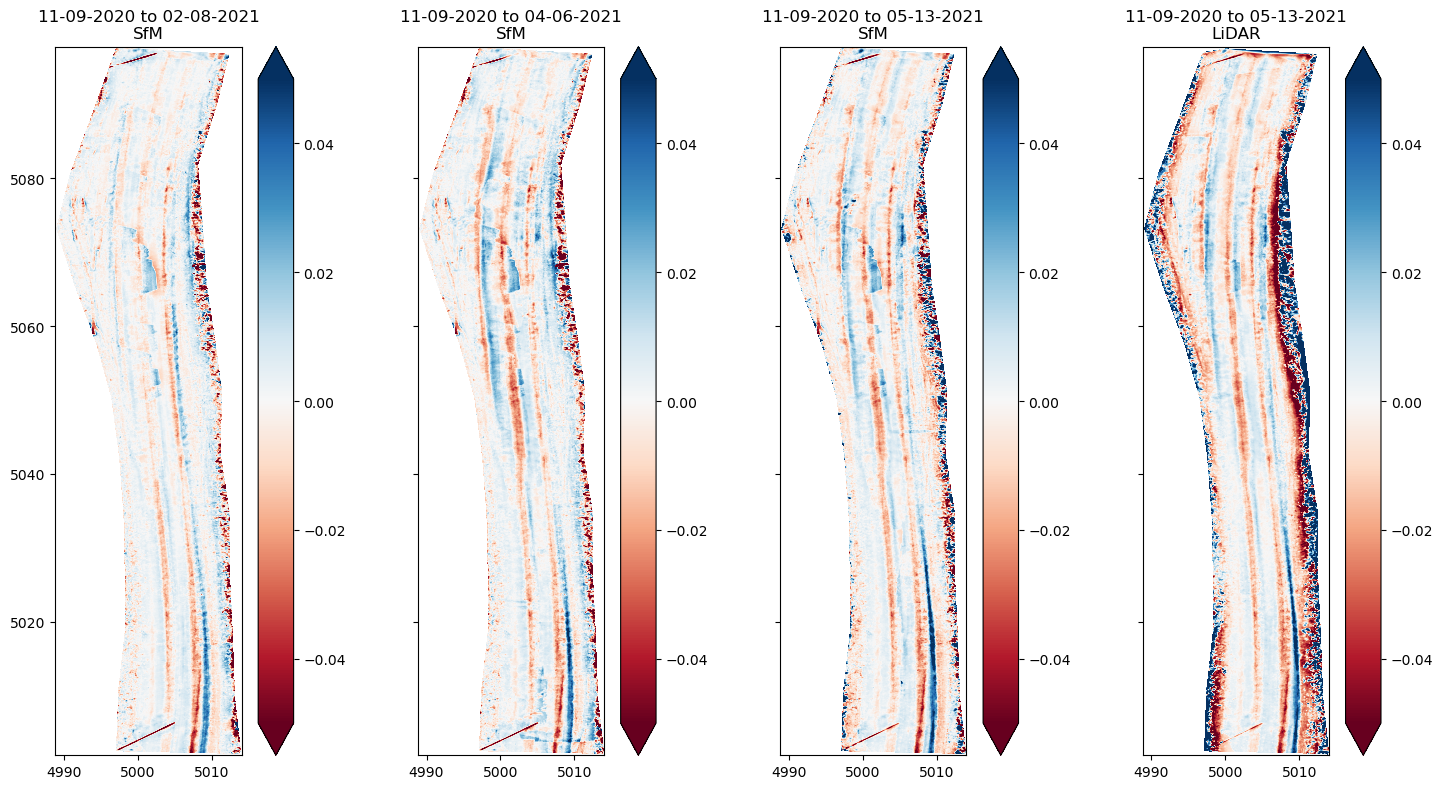

In [16]:
vmin= -0.05
vmax= 0.05

f, axa = plt.subplots(1,4, sharex=True, sharey=True, figsize=(15,8))

m = axa[0].imshow(diff_hp1_2, cmap = color , vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[0], extend='both')#, ax=axa[0]
axa[0].set_title("11-09-2020 to 02-08-2021\nSfM")

m = axa[1].imshow(diff_hp1_3, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[1], extend='both')
axa[1].set_title("11-09-2020 to 04-06-2021\nSfM")

m = axa[2].imshow(diff_hp1_4, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[2], extend='both')
axa[2].set_title("11-09-2020 to 05-13-2021\nSfM")

m = axa[3].imshow(diff_hp_lidar, cmap = color, vmin = vmin, vmax = vmax, extent = da_extent)
f.colorbar(m, ax=axa[3], extend='both')
axa[3].set_title("11-09-2020 to 05-13-2021\nLiDAR")

# plt.savefig('high-pass filter attempt 2, on diff.png', bbox_inches='tight', dpi=300)
plt.tight_layout()

In [17]:
diff_hp1_2.rio.to_raster('KID13_hpgf_20201109_20210208_sfm.tif')
diff_hp1_3.rio.to_raster('KID13_hpgf_20201109_20210406_sfm.tif')
diff_hp1_4.rio.to_raster('KID13_hpgf_20201109_20210513_sfm.tif')
diff_hp_lidar.rio.to_raster('KID13_hpgf_20201109_20210513_LiDAR.tif')

### Longitudinal plot along road
Below is a plot of longitudinal profiles taken across the x-axis of the road, with a step of 0.5 meters. Only those longitudinal profiles that have valid data during most of the length of the road are included here. From this plot we can see that across the road there is a wave occuring that we need to flatten to see more signal and less noise. 

In [ ]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff1_2.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference without high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

Now we can look at the same longitudinal plot on the difference after the high pass filter and see that the long wave-form has been flattened so that the differences are more uniformly distributed about 0. So much better!

In [ ]:
x = np.arange(4994, 4998.5, 0.5)

f, axa = plt.subplots()
ims = []
for i in x:
    ims.append(diff_hp1_2.sel(x=i, method='nearest').plot(ax=axa))
axa.axhline(0, color='k')
axa.set_ylabel('Difference (m)')
axa.set_title('Longitudinal plot of difference with high pass filter')
#attempt to animate but this is all it will show me
# anim = animation.ArtistAnimation(f, ims, interval=2000, repeat_delay=1000)
plt.show()

We can also zoom in on those same areas and see a more meaningful result in micro-topographic feature resolution, with evenly formed ruts that aren't impacted by the road-long waveform

In [ ]:
f, ax = plt.subplots()
plt.imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

b_spot = [0.175,0.16]
a_spot = [0.175, 0.75]

ax.text(b_spot[0],b_spot[1], 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.text(a_spot[0],a_spot[1], 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
#plt.savefig('Difference_MEL_overview=2.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
fig, axa = plt.subplots(nrows=2, ncols=2)

im1 = axa[0,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,0].set_xlim(175,800)
axa[0,0].set_ylim(a_top, a_bottom)
axa[0,0].set_ylabel('Y (m)')
axa[0,0].set_title('Difference with \n High-Pass Filter')

im2 = axa[1,0].imshow(diff_hp, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,0].set_xlim(320,850)
axa[1,0].set_ylim(b_bottom,b_top)
axa[1,0].set_xlabel('X (m)')
axa[1,0].set_ylabel('Y (m)')

im3 = axa[0,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[0,1].set_xlim(175,800)
axa[0,1].set_ylim(a_top, a_bottom)
axa[0,1].set_ylabel('Y (m)')
axa[0,1].set_title('Difference without \n High-Pass Filter')

im4 = axa[1,1].imshow(diff, cmap = color, vmin= vmin, vmax=vmax, extent = da_extent)
#axa[1,1].set_xlim(320,850)
axa[1,1].set_ylim(b_bottom,b_top)
axa[1,1].set_xlabel('X (m)')
axa[1,1].set_ylabel('Y (m)')



cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax, label='Elevation Difference (m)', extend='both')

axa[0,0].text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=axa[0,0].transAxes)
axa[0,1].text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=axa[0,1].transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
#plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()